In [2]:
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
driver = webdriver.Chrome(executable_path = 'chromedriver')

# Login To Instagram

In [33]:
driver.get('https://www.instagram.com/')
time.sleep(3)

#login into instagram

usr_name = driver.find_element(By.NAME,"username")
usr_name.click()
usr_name.send_keys("riyaagg9587")

pswrd = driver.find_element(By.NAME,"password")
pswrd.click()
pswrd.send_keys("Successmile@100")
pswrd.submit()

time.sleep(5)

## Dealing with some Pop-Ups

In [34]:
#saving info

save_info = driver.find_element(By.XPATH,"//button[text()='Not Now']")
save_info.click()
time.sleep(3)

In [35]:
#notifications

notify = driver.find_element(By.XPATH,"//button[text()='Not Now']")
notify.click()
time.sleep(3)

## Searching for the first 10 handles

In [36]:
def text_box(search_this):
    text_box = driver.find_element(By.CLASS_NAME,'x3qfX') 
    text_box.clear() 
    text_box.send_keys(search_this) 

In [37]:
def food_insta_handles():
    text_box('food') 
    time.sleep(4)
    lst = driver.find_elements(By.CLASS_NAME,'yCE8d') # made list of all the elements in list
    insta_handles = []

    # this is done so that only handles are displayed not tags and locations 
    
    for i in lst:
        if ('locations' not in i.get_attribute('href'))  and ('tags' not in i.get_attribute('href')) :
            insta_handles.append(i)
    
    Food_handles = []
    
    for j in range(10) :
        Food_handles.append(insta_handles[j].find_element(By.XPATH,'div/div[2]/div/span').text) 
         
    return Food_handles

In [ ]:
# These are the first 10 followers 

handles = food_insta_handles()
handles

## Search for the top 5 which have highest number of followers

In [39]:
def open_profile(profile_name):
    text_box(profile_name) # calling text_box function to search for given keyword
    time.sleep(3)
    driver.find_element(By.CLASS_NAME,'yCE8d').click()

In [40]:
def top_5_handles():
    Food_handles = food_insta_handles() # getting first 10 food handles
    time.sleep(2)
    d = {}
    for i in Food_handles :
        driver.get('https://www.instagram.com/' + str(i)) 
        time.sleep(3)
        followers = driver.find_elements(By.CLASS_NAME,'g47SY')[1].get_attribute('title') 
        d[i] = int(followers.replace(',','')) 
    
    sorted_dict = sorted(d.items(), key = lambda kv:kv[1], reverse = True)[:5] # sorting the by number of followers 
    return sorted_dict 

In [ ]:
top_handles = top_5_handles()

# printing those handles

for i in top_handles:
    print(i[0])

## Number of posts these handles done in previous 3 days

In [42]:
def Post_count(insta_handles):
    d = {} 
    for i in insta_handles:
        driver.get('https://www.instagram.com/' + str(i[0])) 
        time.sleep(3)
        posts = driver.find_elements(By.CLASS_NAME,'v1Nh3') # finding all posts on page
        count = 0
        posts[0].click() 
        while True : 
            try :
                time.sleep(3)
                upload_time = driver.find_element(By.CLASS_NAME,'_1o9PC').text.split(" ") 
                if (upload_time[1] == 'HOURS' or upload_time[1] == 'HOUR' or upload_time[1] == 'MINUTES') : 
                    count += 1
                elif (int(upload_time[0]) < 3):
                    count += 1
                else :
                    break
                next_button = driver.find_element(By.CLASS_NAME,'_65Bje') 
                next_button.click()
            except ValueError:
                    break
        d[i[0]] = count 
        
    return d


In [ ]:
d = Post_count(top_handles)

print('Food Handle Name', '     ', 'Number of posts in previous 3 days')
for j in d :
    print('     ',j, '             ', d[j])

## Plotting the Graph

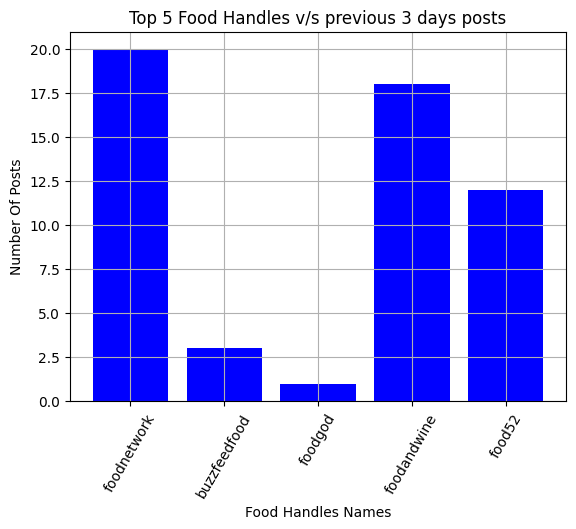

In [44]:
page_name = ['foodnetwork','buzzfeedfood','foodgod','foodandwine','food52']
count = [20,3,1,18,12]
plt.grid()
plt.bar(page_name, count, color = 'blue')
plt.title('Top 5 Food Handles v/s previous 3 days posts')
plt.xlabel('Food Handles Names')
plt.ylabel('Number Of Posts')
plt.xticks(rotation = 60)
plt.show()

## Open those 5 handles and scrap the 1st 10 posts of it

In [45]:
def words_and_hashtags(driver,words,hashtags):
    wait = WebDriverWait(driver, 10)
    #Try opening the first post
    try :
        li = wait.until(EC.presence_of_element_located((By.CLASS_NAME,'v1Nh3')))
        li.click()
    except Exception as e:
        print("Cant Open Post") 
        return
    
    #Loop will run 10 times, since we are to scrape first 10 posts
    for i in range(10):
       
        try: 
            temp = wait.until(EC.presence_of_element_located((By.CLASS_NAME,'_1o9PC')))
        except Exception as e:
            print("Loading error")
            return
        
        #Get the element(post) which represent caption using xpath
        try:
            post = wait.until(EC.presence_of_element_located((By.XPATH,'//article/div[2]/div[1]/ul/div/li/div/div/div[2]/span'))).text

            l = [tag.strip("#") for tag in post.split() if tag.startswith("#")]

            # add hashtags in the dictionary
            for i in l:
                for j in i.split('#') :  
                    hashtags[j] = hashtags.get(j,0) + 1

            # post again split about all non alphabets, this time to contain all the words
            for i in re.split('[^a-zA-Z]',post):
                if i != '':
                    words[i] = words.get(i,0) + 1 
        except Exception as e:
            print('No Caption in post Number', i )
       
        try: 
            nxt = wait.until(EC.presence_of_element_located((By.CLASS_NAME,'coreSpriteRightPaginationArrow')))
            nxt.click()
        except Exception as e:
            print("No more posts")
            break     

    #return both dictionaries
    return words,hashtags

In [46]:
def content(insta_handles):
    words = {} 
    hashtags = {}
    for j in insta_handles: # iterating through each handle.
        driver.get('https://www.instagram.com/' + str(j[0])) 
        time.sleep(3)
        
        words, hashtags = words_and_hashtags(driver,words,hashtags)
        
    return words, hashtags

In [ ]:
words, hashtags = content(top_handles)

print(words)
print(hashtags)

## Creating a csv file

In [ ]:
df = pd.DataFrame(list(zip(words.keys(), words.values())), columns = ['WORD', 'FREQUENCY'])
df   

In [ ]:
df.to_csv('words_and_frequency.csv', index = False )

## Most popular hasgtags

In [ ]:
sorted_hashtags = sorted(hashtags.items(), key = lambda kv:kv[1], reverse = True)
sorted_hashtags

In [ ]:
print('Top 5 most popular hashtags are :-')
print()
for i in range(5):
    print(sorted_hashtags[i][0])

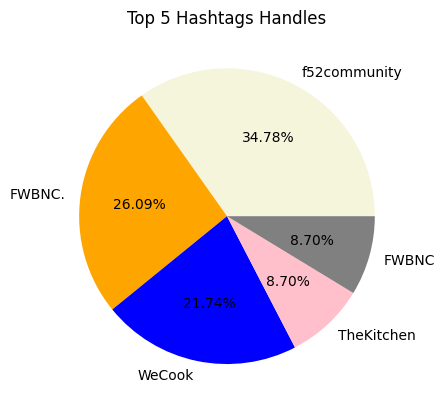

In [51]:
freq = [8,6,5,2,2]
hashtags = ['f52community','FWBNC.','WeCook','TheKitchen','FWBNC']
color = ["beige", "orange", "blue", "pink", "grey"] # giving colors of choices 
plt.pie(freq, labels = hashtags, colors = color, autopct = '%.2f%%')
plt.title('Top 5 Hashtags Handles')
plt.show()

## Likes Ratio

In [6]:
def follower_like_ratio(driver):
    wait = WebDriverWait(driver, 5)

    #Try locating the followers button to get the total number of followers
    try: 
        followers_ele = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME,'g47SY')))[1]
        followers = int(followers_ele.get_attribute('title').replace(',' , ''))  
    except Exception as e:     
        print('Cant access followers')
    
    #Open the first post
    try:
        li = wait.until(EC.presence_of_element_located((By.CLASS_NAME,'v1Nh3')))
        li.click()
    except Exception as e:
        print("Cant Open Post")
        return
    
    #Create a list to keep an account of like of each of the posts
    lst = []
    
    for i in range(10):
        try: 
            
            temp = wait.until(EC.presence_of_element_located((By.CLASS_NAME,'Nm9Fw')))
            if temp.text == '':
                temp = driver.find_elements(By.CLASS_NAME,'Nm9Fw')[-1]
        except Exception as e:     
            try: 
                # Now Locating the views  
                driver.find_element(By.CLASS_NAME,'vcOH2').click()
                #getting likes also
                temp = wait.until(EC.presence_of_element_located((By.CLASS_NAME,'vJRqr')))  
            except Exception as e:
                print("Loading error")
                return
      
        #Calculating likes and then appending to the list
        likes = int(temp.text.split()[0].replace(',',''))
        lst.append(likes)
       
        try: 
            driver.find_element(By.CLASS_NAME,'coreSpriteRightPaginationArrow').click()
        
        except Exception as e:
            try: 
                #click on outside
                driver.find_element(By.CLASS_NAME,'QhbhU').click() 
                #try to click on next button again
                nxt = wait.until(EC.presence_of_element_located((By.CLASS_NAME,'coreSpriteRightPaginationArrow')))
                nxt.click()
            except Exception as e:
                print("No more posts")
                break     
    #calculating the ratio of likes and followers 
    avg_likes = sum(lst)/len(lst)
    ratio = followers/avg_likes
    return ratio 

In [ ]:
for j in top_handles: # visiting each of the handles
        driver.get('https://www.instagram.com/' + str(j[0]))
        time.sleep(3)     
        print(j[0], 'avg likes-')
        follower_like_ratio(driver) 
        

In [ ]:
def all_pages_ratio(insta_handles):
    handle_ratio = {} # making dict for name and its ratio also
    for j in insta_handles: # visiting each of the handle
        driver.get('https://www.instagram.com/' + str(j[0]))
        time.sleep(3)
        handle_ratio[str(j[0])] = follower_like_ratio(driver) # storing ratio of each of the handle along with it's name
        
    return handle_ratio

In [ ]:
handle_ratio = all_pages_ratio(top_handles)  
handle_ratio

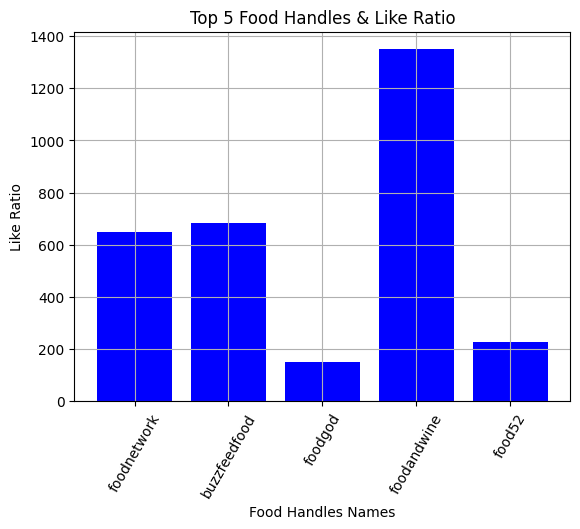

In [4]:
handle_name = ['foodnetwork','buzzfeedfood','foodgod','foodandwine','food52']
like_ratio = [647.017,682.969,150.291,1349.652,226.096]
plt.bar(handle_name, like_ratio, color = 'blue')
plt.title('Top 5 Food Handles & Like Ratio')
plt.xlabel('Food Handles Names')
plt.ylabel('Like Ratio')
plt.xticks(rotation = 60)
plt.grid()
plt.show()

# This is the whole project!